In [59]:
import numpy as np 
import random 
import matplotlib.pyplot as plt 
import networkx as nx
import math
from itertools import combinations

In [60]:
# Function to create a simple block network  NEW
def generate_block_network(block_sizes, prob_matrix):
    """
    Genera una rete basata su un modello a blocchi stocastici (SBM).
    
    :param block_sizes: Lista che specifica il numero di nodi per ciascun blocco.
    :param prob_matrix: Matrice quadrata NxN con le probabilità di connessione tra i blocchi.
    :return: Un oggetto Graph di NetworkX.
    """
    num_blocks = len(block_sizes)
    num_nodes = sum(block_sizes)
    G = nx.Graph()
    
    # Creazione dei nodi con etichetta di blocco
    node_labels = []
    current_label = 0
    for i, size in enumerate(block_sizes):
        for _ in range(size):
            G.add_node(current_label, block=i)
            node_labels.append(current_label)
            current_label += 1
    
    # Aggiunta degli archi basati sulla probabilità nella matrice di adiacenza
    start_idx = 0
    for i in range(num_blocks):
        end_idx = start_idx + block_sizes[i]
        start_jdx = 0
        for j in range(num_blocks):
            end_jdx = start_jdx + block_sizes[j]
            
            for u in range(start_idx, end_idx):
                for v in range(start_jdx, end_jdx):
                    if u < v and np.random.rand() < prob_matrix[i][j]:
                        G.add_edge(u, v)
            
            start_jdx = end_jdx
        start_idx = end_idx
    
    return G

def get_adjacency_matrix(G):        # NEW
    """Calcola la matrice di adiacenza della rete G."""
    return nx.to_numpy_array(G)

def modify_network(G, modification_fraction):
    """Rimuove e aggiunge casualmente una frazione di collegamenti nella rete G."""
    G_modified = G.copy()
    edges = list(G.edges())
    nodes = list(G.nodes())
    num_to_modify = int(len(edges) * modification_fraction)
    
    removed_edges = []
    added_edges = []
    
    # Rimuovi collegamenti casuali
    edges_to_remove = np.random.choice(len(edges), num_to_modify // 2, replace=False)
    for idx in edges_to_remove:
        removed_edges.append(edges[idx])
        G_modified.remove_edge(*edges[idx])
    
    # Aggiungi collegamenti casuali
    for _ in range(num_to_modify // 2):
        u, v = np.random.choice(nodes, 2, replace=False)
        if not G_modified.has_edge(u, v):
            G_modified.add_edge(u, v)
            added_edges.append((u, v))
    
    return G_modified, removed_edges, added_edges

def plot_modified_network(G, removed_edges, added_edges, title):
    """Plotta la rete osservata con rimozioni e aggiunte evidenziate."""
    pos = nx.spring_layout(G)
    
    plt.figure(figsize=(8, 6))
    nx.draw(G, pos, with_labels=True, node_color='skyblue', edge_color='gray') # node_color=[G.nodes[n]['block']for n in G.nodes()])
    nx.draw_networkx_edges(G, pos, edgelist=removed_edges, edge_color='red', style='dashed', width=2)
    nx.draw_networkx_edges(G, pos, edgelist=added_edges, edge_color='green', style='solid', width=2)
    #plt.title("Rete Osservata con Link Rimossi (rosso tratteggiato) e Aggiunti (verde)")
    plt.title(title)
    plt.show()

In [61]:
def initialize_partition(G):
    """Initialize random partitions (each node is its own group)."""
    num_nodes = len(G.nodes())
    return {node: random.choice(range(num_nodes)) for node in G.nodes()}  # Randomly assign each node to a group
    #return {node: node for node in G.nodes()}  # Every node is its own group initially

def calculate_H(P, G):
    """Calcola H(P) per una data partizione P e il grafo G."""
    # Raggruppa i nodi per blocco
    block_nodes = {}
    for node, group in P.items():
        block_nodes.setdefault(group, []).append(node)

    lO = {}  # Observed links between blocks
    r = {}   # Possible links between blocks
    
    # Count links in the observed network
    for u, v in G.edges():
        gu, gv = P[u], P[v]
        key = tuple(sorted([gu, gv]))
        lO[key] = lO.get(key, 0) + 1
    
    # Compute rαβ (max possible links between groups)
    groups = list(block_nodes.keys())
    for g in groups:
        n = len(block_nodes[g])
        r[(g, g)] = n * (n - 1) // 2  # combinazioni di 2
    # Coppie di gruppi differenti
    for g1, g2 in combinations(groups, 2):
        r[tuple(sorted([g1, g2]))] = len(block_nodes[g1]) * len(block_nodes[g2])
    
    # Compute H(P)
    H = 0.0
    for key in r:
        # Nota: aggiungiamo 1 al denominatore come da formula e usiamo log(comb) per il termine combinatorio.
        H += math.log(r[key] + 1)
        # Per evitare log(0) o errori, usiamo 0 se non ci sono link osservati
        links = lO.get(key, 0)
        try:
            comb_value = math.comb(r[key], links) if r[key] >= links else 1
        except ValueError:
            comb_value = 1
        # Per sicurezza, se comb_value risulta 0, aggiungiamo un epsilon
        H += math.log(comb_value + 1e-10)
    
    return H
    

def metropolis_MCMC(G, num_samples=10000, equilibration=1000):
    """Esegue il campionamento MCMC per esplorare lo spazio delle partizioni."""
    num_nodes = len(G.nodes())
    P = initialize_partition(G)  # Initial partition
    partitions = []
    
    # Equilibrazione (scarti iniziali)
    for _ in range(equilibration):
        node = random.choice(list(G.nodes()))
        old_group = P[node]
        new_group = random.choice(range(num_nodes))
        old_H = calculate_H(P, G)
        P[node] = new_group
        new_H = calculate_H(P, G)
        delta_H = new_H - old_H
        if delta_H > 0 and np.random.rand() >= np.exp(-delta_H):
            P[node] = old_group  # ripristina se mossa rifiutata
        
        # Campionamento delle partizioni
    for _ in range(num_samples):
        node = random.choice(list(G.nodes()))
        old_group = P[node]
        new_group = random.choice(range(num_nodes))
        
        old_H = calculate_H(P, G)
        P[node] = new_group
        new_H = calculate_H(P, G)
        delta_H = new_H - old_H
        
        if delta_H > 0 and np.random.rand() >= np.exp(-delta_H):
            P[node] = old_group  # ripristina se mossa rifiutata
        
        # Salva una copia della partizione corrente
        partitions.append(P.copy())
    
    return partitions
    

def estimate_link_reliability(G, partitions):
    """
    Stima la link reliability RL_ij per ogni coppia (i,j) con i < j
    secondo la formula:
    
    RL_ij = (1/Z) * sum_{P in partitions} [ (lO_{σ_iσ_j}+1)/(r_{σ_iσ_j}+2) * exp(-H(P) ) ]
    """
    # Inizializza dizionario per RL per tutte le coppie (i,j)
    nodes = list(G.nodes())
    reliability = {}
    for i in range(len(nodes)):
        for j in range(i+1, len(nodes)):
            reliability[(i, j)] = 0.0

    Z = 0.0  # normalizzatore
    
    for P in partitions:
        weight = np.exp(-calculate_H(P, G))
        Z += weight
        
        # Raggruppa nodi per blocco per la partizione P
        block_nodes = {}
        for node, group in P.items():
            block_nodes.setdefault(group, []).append(node)
        
        # Pre-calcola r e lO per ogni coppia di blocchi per la partizione P
        r = {}
        lO = {}
        groups = list(block_nodes.keys())
        # Per i blocchi identici
        for g in groups:
            n = len(block_nodes[g])
            r[(g, g)] = n * (n - 1) // 2
            # Conta i link osservati all'interno del blocco
            count = 0
            for u, v in combinations(block_nodes[g], 2):
                if G.has_edge(u, v):
                    count += 1
            lO[(g, g)] = count
        # Per coppie di blocchi differenti
        for g1, g2 in combinations(groups, 2):
            key = tuple(sorted([g1, g2]))
            r[key] = len(block_nodes[g1]) * len(block_nodes[g2])
            count = 0
            for u in block_nodes[g1]:
                for v in block_nodes[g2]:
                    if G.has_edge(u, v):
                        count += 1
            lO[key] = count
        
        # Per ogni coppia di nodi (i, j), applica la formula in base ai gruppi di P
        for i in range(len(nodes)):
            for j in range(i+1, len(nodes)):
                g_i = P[nodes[i]]
                g_j = P[nodes[j]]
                key = tuple(sorted([g_i, g_j]))
                # Se il blocco non ha archi osservati, lO restituisce 0
                current_lO = lO.get(key, 0)
                current_r = r.get(key, 1)  # evitiamo divisioni per zero
                reliability[(nodes[i], nodes[j])] += ((current_lO + 1) / (current_r + 2)) * weight

    # Normalizzazione
    for key in reliability:
        reliability[key] /= Z
    
    return reliability

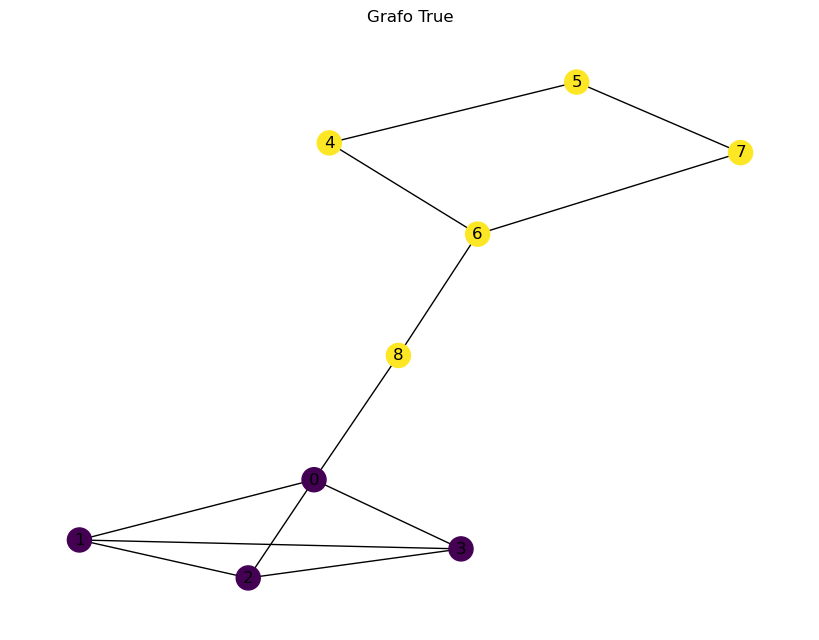

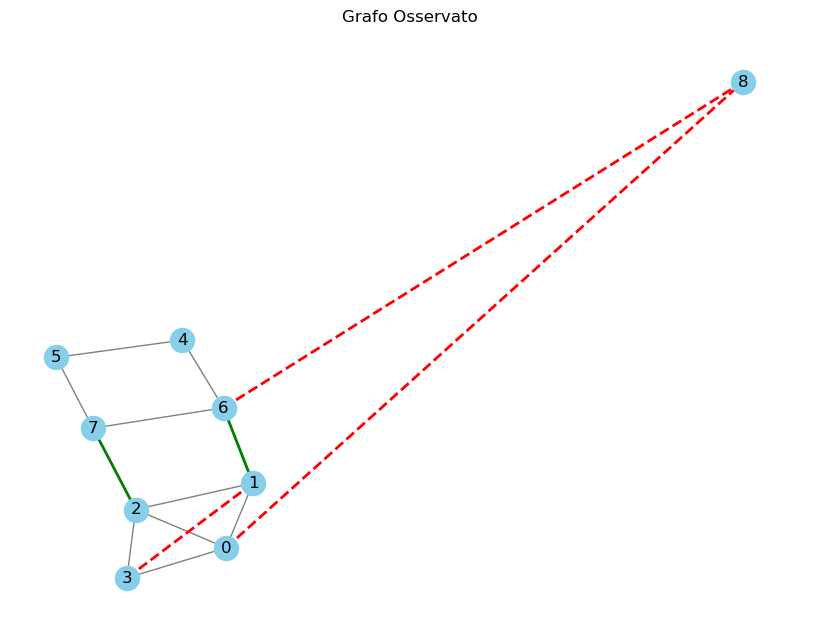

Link Reliability per alcune coppie di nodi:
Coppia (0, 1): RL = 0.6318
Coppia (0, 2): RL = 0.7399
Coppia (0, 3): RL = 0.7119
Coppia (0, 4): RL = 0.2057
Coppia (0, 5): RL = 0.1921
Coppia (0, 6): RL = 0.2073
Coppia (0, 7): RL = 0.2717
Coppia (0, 8): RL = 0.1936
Coppia (1, 2): RL = 0.6900
Coppia (1, 3): RL = 0.5026
Coppia (1, 4): RL = 0.1943
Coppia (1, 5): RL = 0.3384
Coppia (1, 6): RL = 0.3953
Coppia (1, 7): RL = 0.2218
Coppia (1, 8): RL = 0.2153
Coppia (2, 3): RL = 0.7666
Coppia (2, 4): RL = 0.3066
Coppia (2, 5): RL = 0.2097
Coppia (2, 6): RL = 0.2172
Coppia (2, 7): RL = 0.4295
Coppia (2, 8): RL = 0.2527
Coppia (3, 4): RL = 0.1828
Coppia (3, 5): RL = 0.2122
Coppia (3, 6): RL = 0.2338
Coppia (3, 7): RL = 0.2401
Coppia (3, 8): RL = 0.1944
Coppia (4, 5): RL = 0.6532
Coppia (4, 6): RL = 0.6585
Coppia (4, 7): RL = 0.3122
Coppia (4, 8): RL = 0.3126
Coppia (5, 6): RL = 0.3419
Coppia (5, 7): RL = 0.6741
Coppia (5, 8): RL = 0.3386
Coppia (6, 7): RL = 0.6768
Coppia (6, 8): RL = 0.3348
Coppia (7, 

In [62]:

# Creiamo una rete con un modello a blocchi semplice
block_sizes = [4, 5]
prob_matrix = [[0.6, 0.2],
                [0.2, 0.5]]
# Genera il grafo "true" usando il modello a blocchi
G_true = generate_block_network(block_sizes, prob_matrix)
# Plotta il grafo "true"
pos_true = nx.spring_layout(G_true)
plt.figure(figsize=(8, 6))
nx.draw(G_true, pos_true, with_labels=True, node_color=[G_true.nodes[n]['block'] for n in G_true.nodes()], edge_color='black')
plt.title("Grafo True")
plt.show()


# Crea una rete osservata modificando casualmente il grafo true
modification_fraction = 0.5  # ad esempio, modifica il 10% dei collegamenti
G_obs, removed_edges, added_edges = modify_network(G_true, modification_fraction)
    
# Plotta il grafo osservato con evidenziazione dei cambiamenti
plot_modified_network(G_obs, removed_edges, added_edges, title="Grafo Osservato")
    
# Esegue il campionamento MCMC sulle partizioni della rete osservata
partitions = metropolis_MCMC(G_obs, num_samples=500, equilibration=100)

# Stima la link reliability per ogni coppia di nodi sulla rete osservata
RL = estimate_link_reliability(G_obs, partitions)
    
# Stampa alcuni risultati (ad esempio per le prime 10 coppie)
print("Link Reliability per alcune coppie di nodi:")
for i, key in enumerate(RL):
    #if i >= 30:
        #break
    print(f"Coppia {key}: RL = {RL[key]:.4f}")




Obiettivo

    Missing Interactions (False Negatives):

        Consideriamo tutte le coppie (i,j)(i,j) per cui il collegamento vera esiste in ATAT​ (grafo true), ma non è stato osservato in AOAO​ (grafo osservato). Queste sono i falsi negativi.

        Separatamente, consideriamo le coppie (i,j)(i,j) per cui non esiste il collegamento in ATAT​ (veri negativi), e che in AOAO​ risultano anch'esse assenti.

        Ordinando in ordine decrescente le stime di link reliability RLijRLij​, si calcola la probabilità che un falso negativo abbia un valore RLRL più alto (cioè, venga classificato prima) rispetto a un vero negativo.

    Spurious Interactions (False Positives):

        Consideriamo le coppie (i,j)(i,j) per cui il collegamento non esiste in ATAT​ (vero negativo), ma in AOAO​ è presente (falso positivo).

        In parallelo, consideriamo le coppie (i,j)(i,j) in cui il collegamento esiste in entrambi i grafi (veri positivi).

        Ordinando in ordine decrescente i RLijRLij​, calcoliamo la probabilità che un falso positivo abbia un RLRL più basso (cioè, venga classificato dopo) rispetto a un vero positivo.

Queste misure sono molto simili all’area sotto la curva (AUC) in un’analisi ROC. In sostanza, per ciascuna delle due situazioni, si considerano tutte le coppie formate da un esempio "positivo" (cioè, il caso in cui il collegamento è “vero”, anche se non osservato nel primo caso, o è osservato e vero nel secondo) e uno "negativo", e si calcola la frazione delle coppie in cui il modello classifica correttamente il caso “positivo” con un punteggio maggiore (oppure, per il secondo caso, con un punteggio maggiore rispetto al falso).

In [63]:
def rank_probability_missing_interactions(G_true, G_obs, RL):
    """
    Calcola la probabilità che un falso negativo (AO=0, AT=1) abbia un RL
    maggiore di un vero negativo (AO=0, AT=0).
    
    G_true: grafo true (AT)
    G_obs: grafo osservato (AO)
    RL: dizionario delle link reliability per ogni coppia (i,j) con i<j.
    """
    false_negatives = []  # AO=0, AT=1
    true_negatives = []   # AO=0, AT=0
    
    nodes = list(G_true.nodes())
    A_true = nx.to_numpy_array(G_true)
    A_obs = nx.to_numpy_array(G_obs)
    
    # Costruiamo le liste delle coppie in base alle definizioni
    for i in range(len(nodes)):
        for j in range(i+1, len(nodes)):
            if A_obs[i, j] == 0:
                if A_true[i, j] == 1:
                    false_negatives.append(RL[(i, j)])
                else:
                    true_negatives.append(RL[(i, j)])
    
    # Se non ci sono esempi, ritorna None o 0
    if not false_negatives or not true_negatives:
        return None
    
    count = 0
    total = 0
    # Per ogni coppia, sommiamo 1 se il falso negativo ha RL > RL del vero negativo,
    # 0.5 se sono uguali.
    for fn in false_negatives:
        for tn in true_negatives:
            total += 1
            if fn > tn:
                count += 1
            elif fn == tn:
                count += 0.5
    probability = count / total
    return probability

def rank_probability_spurious_interactions(G_true, G_obs, RL):
    """
    Calcola la probabilità che un falso positivo (AO=1, AT=0) abbia un RL
    inferiore a un vero positivo (AO=1, AT=1).
    
    G_true: grafo true (AT)
    G_obs: grafo osservato (AO)
    RL: dizionario delle link reliability per ogni coppia (i,j) con i<j.
    """
    false_positives = []  # AO=1, AT=0
    true_positives = []   # AO=1, AT=1
    
    nodes = list(G_true.nodes())
    A_true = nx.to_numpy_array(G_true)
    A_obs = nx.to_numpy_array(G_obs)
    
    for i in range(len(nodes)):
        for j in range(i+1, len(nodes)):
            if A_obs[i, j] == 1:
                if A_true[i, j] == 0:
                    false_positives.append(RL[(i, j)])
                else:
                    true_positives.append(RL[(i, j)])
    
    if not false_positives or not true_positives:
        return None
    
    count = 0
    total = 0
    # Ora vogliamo che il falso positivo abbia RL inferiore rispetto al vero positivo,
    # cioè, in un ordinamento decrescente il vero positivo deve venire prima.
    for fp in false_positives:
        for tp in true_positives:
            total += 1
            if fp < tp:
                count += 1
            elif fp == tp:
                count += 0.5
    probability = count / total
    return probability



In [64]:
# Calcola la probabilità per missing interactions (falsi negativi)
p_missing = rank_probability_missing_interactions(G_true, G_obs, RL)
if p_missing is not None:
    print(f"Probabilità che un falso negativo abbia un RL più alto di un vero negativo: {p_missing:.4f}")
else:
    print("Non ci sono abbastanza esempi per missing interactions.")
    
# Calcola la probabilità per spurious interactions (falsi positivi)
p_spurious = rank_probability_spurious_interactions(G_true, G_obs, RL)
if p_spurious is not None:
    print(f"Probabilità che un falso positivo abbia un RL più basso di un vero positivo: {p_spurious:.4f}")
else:
    print("Non ci sono abbastanza esempi per spurious interactions.")

Probabilità che un falso negativo abbia un RL più alto di un vero negativo: 0.6515
Probabilità che un falso positivo abbia un RL più basso di un vero positivo: 1.0000



# Creiamo una rete con un modello a blocchi semplice
block_sizes = [4, 5]
prob_matrix = [[0.6, 0.2],
                [0.2, 0.5]]
# Genera il grafo "true" usando il modello a blocchi
G_true = generate_block_network(block_sizes, prob_matrix)
# Plotta il grafo "true"
pos_true = nx.spring_layout(G_true)
plt.figure(figsize=(8, 6))
nx.draw(G_true, pos_true, with_labels=True, node_color=[G_true.nodes[n]['block'] for n in G_true.nodes()], edge_color='black')
plt.title("Grafo True")
plt.show()


# Crea una rete osservata modificando casualmente il grafo true
modification_fraction = 0.5  # ad esempio, modifica il 10% dei collegamenti
G_obs, removed_edges, added_edges = modify_network(G_true, modification_fraction)
    
# Plotta il grafo osservato con evidenziazione dei cambiamenti
plot_modified_network(G_obs, removed_edges, added_edges, title="Grafo Osservato")
    
# Esegue il campionamento MCMC sulle partizioni della rete osservata
partitions = metropolis_MCMC(G_obs, num_samples=500, equilibration=100)

# Stima la link reliability per ogni coppia di nodi sulla rete osservata
RL = estimate_link_reliability(G_obs, partitions)
    
# Stampa alcuni risultati (ad esempio per le prime 10 coppie)
print("Link Reliability per alcune coppie di nodi:")
for i, key in enumerate(RL):
    #if i >= 30:
        #break
    print(f"Coppia {key}: RL = {RL[key]:.4f}")


